# Image Data Loss Exploratory Analysis

## Setup Environment

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
# machine learning
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models

!pip3 install progressbar
import progressbar

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=c60e3c647cf0256cbd817cb20b34862ab14c369dd3ace6d87a3f3aec229da55b
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built progressbar


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Load MNIST Dataset

In [3]:
# import mnist dataset
BATCH_SIZE = 500

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/kaggle/working',
                               train=True,
                               download=True,
                               transform=torchvision.transforms.ToTensor()),
    batch_size=BATCH_SIZE,shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/kaggle/working',
                               train=False,
                               download=True,
                               transform=torchvision.transforms.ToTensor()),
    batch_size=BATCH_SIZE,shuffle=True)

0it [00:00, ?it/s]

Extracting /kaggle/working/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/MNIST/raw


0it [00:00, ?it/s]

Extracting /kaggle/working/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/MNIST/raw


0it [00:00, ?it/s]

Extracting /kaggle/working/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/MNIST/raw


0it [00:00, ?it/s]

Extracting /kaggle/working/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/MNIST/raw
Processing...
Done!


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## MNIST Classifier / Baseline Model

In [4]:
class BasicClassifier(nn.Module):
    def __init__(self,num_classes) -> None:
        self.num_classes = num_classes
        self.metric = Metrics()
        super(BasicClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,64,kernel_size=7),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,128,kernel_size=11),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,182,kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(182,256,kernel_size=5),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096,2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,num_classes),
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Model Trainer

In [5]:
def train(model,train_loader,datafunc,proportion,optimizer,criterion,NUM_CLASSSES=10,NUM_EPOCHS=15):
    epoch_metrics = {}
    bar = progressbar.ProgressBar(NUM_EPOCHS*len(train_loader),widgets=widgets).start()
    for epoch in range(NUM_EPOCHS):
        model.metric.reset_confusion_matrix(NUM_CLASSSES)
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(datafunc(inputs,proportion).to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            # statistics
            model.metric.update_confusion_matrix(outputs.to('cpu'),labels)
            # progressbar
            bar.update(epoch*len(train_loader)+i)
        epoch_metrics[epoch] = model.metric.classification_metrics()
    return epoch_metrics

def display_training_metrics(name,epoch_metrics):
    sns.lineplot(x=list(epoch_metrics.keys()),y=np.array(list(epoch_metrics.values()),dtype=float)[:,1]) # precision
    sns.lineplot(x=list(epoch_metrics.keys()),y=np.array(list(epoch_metrics.values()),dtype=float)[:,2]) # recall
    sns.lineplot(x=list(epoch_metrics.keys()),y=np.array(list(epoch_metrics.values()),dtype=float)[:,0],) # accuracy
    plt.xlabel('epoch')
    plt.title(name)
    

def display_testing_metrics(name,epoch_metrics):
    sns.lineplot(x=list(epoch_metrics.keys()),y=np.array(list(epoch_metrics.values()),dtype=float)[:,1]) # precision
    sns.lineplot(x=list(epoch_metrics.keys()),y=np.array(list(epoch_metrics.values()),dtype=float)[:,2]) # recall
    sns.lineplot(x=list(epoch_metrics.keys()),y=np.array(list(epoch_metrics.values()),dtype=float)[:,0],) # accuracy
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('% loss')
    plt.title(name)

## Metrics Class

In [6]:
class Metrics:
    def __init__(self):
        pass
    
    def update_confusion_matrix(self, outputs: torch.Tensor, labels: torch.Tensor) -> None:       
        for (guess,label) in zip(outputs.argmax(1),labels):
            self.confusion_matrix[guess,label] += 1
            
    def get_confusion_matrix(self,norm=False) -> np.array:
        if norm:
            return self.confusion_matrix / self.confusion_matrix.sum()
        return self.confusion_matrix
    
    def reset_confusion_matrix(self,num_classes: int) -> None:
        self.confusion_matrix = np.zeros((num_classes,num_classes))
    
    def classification_metrics(self,print_=False) -> tuple:
        stats = [self.accuracy(),self.precision(),self.recall(),self.f1_score(),self.confusion_matrix.sum()]
        s = "Accuracy: {}\nPrecision: {}\nRecall: {}\nf1-score: {}\nSupport: {}".format(stats[0],stats[1],stats[2],stats[3],stats[4])
        if print_:
            print(s)
        return stats
    
    def accuracy(self) -> float:
        stat = np.diag(self.confusion_matrix).sum() / self.confusion_matrix.sum()
        if np.isnan(stat) or np.isinf(stat):
            return 0.0
        else:
            return stat
        
    def precision(self) -> float:
        stat = np.nanmean(np.diag(self.confusion_matrix) / np.sum(self.confusion_matrix, axis = 0))
        if np.isnan(stat) or np.isinf(stat):
            return 0.0
        else:
            return stat
        return stat
        
    def recall(self) -> float:
        stat = np.nanmean(np.diag(self.confusion_matrix) / np.sum(self.confusion_matrix, axis = 1))
        if np.isnan(stat) or np.isinf(stat):
            return 0.0
        return stat
    
    def f1_score(self) -> float:
        p = self.precision()
        r = self.recall()
        stat = 2.0*(p*r)/(p+r)
        if np.isnan(stat):
            return 0.0
        else:
            return stat
    
    def feature_map(self,inputs: torch.Tensor,model,print_=False):
        no_of_layers=0
        conv_layers=[]

        model_children=list(model.children())

        for child in model_children:
            if type(child)==nn.Conv2d:
                conv_layers.append(child)
            elif type(child) == nn.Sequential:
                for layer in child.children():
                    if type(layer) == nn.Conv2d:
                        conv_layers.append(layer)
#         (inputs,labels) = next(iter(test_loader))
        results = [conv_layers[0](inputs.to(device))]
        for i in range(1, len(conv_layers)):
            results.append(conv_layers[i](results[-1]))
        outputs = results
        if print_:
            plt.imshow(inputs[0,0].to('cpu'),cmap='Greys')
            plt.show()
            for num_layer in range(len(outputs)):
                plt.figure(figsize=(50, 10))
                layer_viz = outputs[num_layer][0, :, :, :]
                layer_viz = layer_viz.data
#                 print("Layer ",num_layer+1)
                for i, filter in enumerate(layer_viz.to('cpu')):
                    if i == 8: 
                        break
                    plt.subplot(2, 8, i + 1)
                    plt.imshow(filter, cmap='gray')
                    plt.axis("off")
                plt.show()
                plt.close()
        return results
    
    def feature_map_diff(map1,map1_loss) -> np.array:
        pass
metric = Metrics()

# Data Loss Class




In [7]:
class DataLoss:
    def __init__(self):
        pass
    def unaltered(self,inputs: torch.Tensor,ppp: float=0.0) -> torch.Tensor:
        return inputs
    
    def random_per_pixel(self,inputs: torch.Tensor,ppp: float=0.0) -> torch.Tensor:
        # ppp: proportion per pixel
        lossyinputs = torch.clone(inputs)
        mask = torch.Tensor(np.random.rand(inputs.shape[0],inputs.shape[1],inputs.shape[2],inputs.shape[3]))
        lossyinputs = lossyinputs * (mask > ppp)
        return lossyinputs.type(torch.FloatTensor)
    
    def random_per_img(self,inputs: torch.Tensor,ppp: float=0.0) -> torch.Tensor:
        if int(inputs.shape[2]*inputs.shape[3]*ppp) < 1:
            return inputs
        if ppp > 1.0:
            ppp = 1.0
        num_loss = int(inputs.shape[2]*inputs.shape[3]*ppp)
        lossyinputs = torch.clone(inputs)
        mask = np.concatenate((np.zeros((inputs.shape[0],num_loss)),np.ones((inputs.shape[0],int(inputs.shape[2]*inputs.shape[3] - num_loss)))),axis=1)
        for i in range(inputs.shape[0]):
            np.random.shuffle(mask[i])
        mask = torch.Tensor(mask.reshape((inputs.shape[0],inputs.shape[1],inputs.shape[2],inputs.shape[3])))
        lossyinputs *= mask
        return lossyinputs.type(torch.FloatTensor)
    
    def columns_per_img(self,inputs: torch.Tensor,ppp: float=0.0) -> torch.Tensor:
        num_col = int(inputs.shape[3]*ppp)
        to_rem = np.random.choice([x for x in range(inputs.shape[2])],size=num_col,replace=False)
        mask = np.ones((inputs.shape[0],inputs.shape[1],inputs.shape[2],inputs.shape[3]))
        for col in to_rem:
            mask[:,:,:,col] = 0
        lossyinputs = torch.clone(inputs)*mask
        return lossyinputs.type(torch.FloatTensor)
    
    def rows_per_img(self,inputs: torch.Tensor,ppp: float=0.0) -> torch.Tensor:
        num_row = int(inputs.shape[2]*ppp)
        to_rem = np.random.choice([x for x in range(inputs.shape[2])],size=num_row,replace=False)
        mask = np.ones((inputs.shape[0],inputs.shape[1],inputs.shape[2],inputs.shape[3]))
        for row in to_rem:
            mask[:,:,row,:] = 0
        lossyinputs = torch.clone(inputs)*mask
        return lossyinputs.type(torch.FloatTensor)
    
    def rowcol_per_img(self,inputs: torch.Tensor,ppp: float=0.0) -> torch.Tensor:
        lossyinputs = torch.clone(inputs)
        lossyinputs = self.rows_per_img(lossyinputs,ppp*.85)
        lossyinputs = self.columns_per_img(lossyinputs,ppp*.85)
        return lossyinputs.type(torch.FloatTensor)
    
dloss = DataLoss()

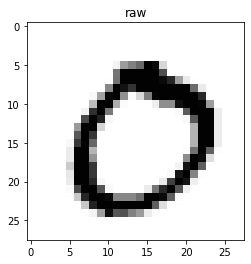

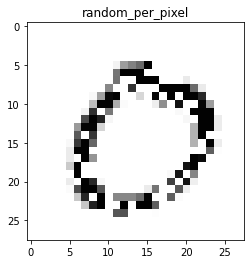

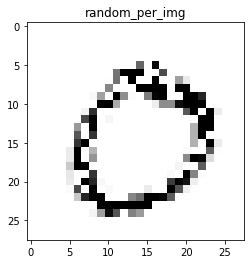

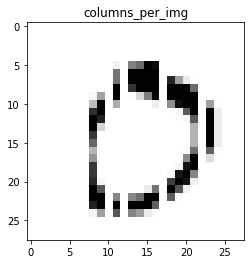

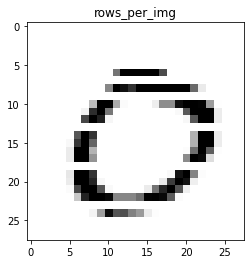

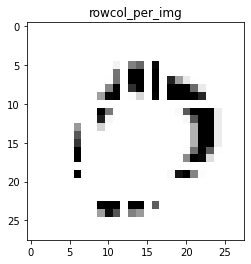

In [8]:
inputs = next(iter(train_loader))[0]
plt.imshow(inputs[0][0],cmap='Greys')
plt.title('raw')
plt.show()
plt.imshow(dloss.random_per_pixel(inputs,0.3)[0][0],cmap='Greys')
plt.title('random_per_pixel')
plt.show()
plt.imshow(dloss.random_per_img(inputs,0.3)[0][0],cmap='Greys')
plt.title('random_per_img')
plt.show()
plt.imshow(dloss.columns_per_img(inputs,0.3)[0][0],cmap='Greys')
plt.title('columns_per_img')
plt.show()
plt.imshow(dloss.rows_per_img(inputs,0.3)[0][0],cmap='Greys')
plt.title('rows_per_img')
plt.show()
plt.imshow(dloss.rowcol_per_img(inputs,0.3)[0][0],cmap='Greys')
plt.title('rowcol_per_img')
plt.show()

# Model trained on unaltered data

In [9]:
# model_unaltered = BasicClassifier(10)
# model_unaltered.to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model_unaltered.parameters(),lr=3e-5)

In [10]:
widgets = [
    ' [', progressbar.Timer(), '] ',
    progressbar.Percentage(), ' ',
    progressbar.Bar(),
    ' (', progressbar.ETA(), ') ',
]

## Train model_unaltered on Unaltered Data

In [11]:
# training
# find best number of epochs
# NUM_EPOCHS = 20
# epoch_metrics = {}
# bar = progressbar.ProgressBar(NUM_EPOCHS*len(train_loader),widgets=widgets).start()
# for epoch in range(NUM_EPOCHS):
#     metric.reset_confusion_matrix(10)
#     for i, (inputs, labels) in enumerate(train_loader):
#         optimizer.zero_grad()
#         outputs = model_unaltered(inputs.to(device))
#         loss = criterion(outputs, labels.to(device))
#         loss.backward()
#         optimizer.step()
#         # statistics
#         metric.update_confusion_matrix(outputs.to('cpu'),labels)
#         # progressbar
#         bar.update(epoch*len(train_loader)+i)
#     epoch_metrics[epoch] = metric.classification_metrics()

In [12]:
# leg = ['accuracy','precision','recall']
# sns.lineplot(x=list(epoch_metrics.keys()),y=np.array(list(epoch_metrics.values()),dtype=float)[:,0],) # accuracy
# sns.lineplot(x=list(epoch_metrics.keys()),y=np.array(list(epoch_metrics.values()),dtype=float)[:,1]) # precision
# sns.lineplot(x=list(epoch_metrics.keys()),y=np.array(list(epoch_metrics.values()),dtype=float)[:,2]) # recall
# plt.legend(leg)
# plt.xlabel('epoch')
# plt.title('Training Unaltered Model on Unaltered Data')
# plt.show()

## Test model_unaltered on Unaltered Data

In [13]:
# testing
# metric.reset_confusion_matrix(10)
# bar = progressbar.ProgressBar(len(test_loader),widgets=widgets).start()
# with torch.no_grad():
#     running_loss = 0.0
#     for i, (inputs, labels) in enumerate(test_loader):
#         outputs = model_unaltered(inputs.to(device))
#         # statistics
#         metric.update_confusion_matrix(outputs.to('cpu'),labels)
#         # progressbar
#         bar.update(i)
# m = metric.get_confusion_matrix(norm=True)
# sns.heatmap(m,square=True,cmap='Greys')
# plt.title('Testing Unaltered Model on Unaltered Data')
# plt.show()
# metric.classification_metrics(print_=True)

## Test model_unaltered on Lossy Data

### DataLoss::random_per_img()

In [14]:
# loss_stats = {}
# percents = [x/10.0 for x in range(0,10)] + [0.95] # input parameters to DataLoss::random_per_img()
# bar = progressbar.ProgressBar(len(percents),widgets=widgets).start()
# for cc, ppp in enumerate(percents):
#     metric.reset_confusion_matrix(10)
#     with torch.no_grad():
#         running_loss = 0.0
#         for i, (inputs, labels) in enumerate(test_loader):
#             outputs = model_unaltered(dloss.random_per_img(inputs,ppp).to(device)) # apply data loss
#             # statistics
#             metric.update_confusion_matrix(outputs.to('cpu'),labels)
#             # progressbar
#     bar.update(cc)
#     loss_stats[ppp] = metric.classification_metrics()

# leg = ['accuracy','precision','recall']
# sns.lineplot(x=list(loss_stats.keys()),y=np.array(list(loss_stats.values()),dtype=float)[:,0],) # accuracy
# sns.lineplot(x=list(loss_stats.keys()),y=np.array(list(loss_stats.values()),dtype=float)[:,1]) # precision
# sns.lineplot(x=list(loss_stats.keys()),y=np.array(list(loss_stats.values()),dtype=float)[:,2]) # recall
# plt.legend(leg)
# plt.xlabel('% loss')
# plt.title('Testing Unaltered Model on Lossy Data(Proportion of Pixels per Image)')
# plt.show()

# Feature Map
https://androidkt.com/how-to-visualize-feature-maps-in-convolutional-neural-networks-using-pytorch/

## Feature Map without DataLoss

In [15]:
# (inputs,labels) = next(iter(test_loader))
# res_full = metric.feature_map(inputs[0:1],model,print_=True)
# print(model(inputs[0:1].to(device)).to('cpu').argmax())

## Feature Map with DataLoss

In [16]:
# (inputs,labels) = next(iter(test_loader))
# loss_inputs = dloss.random_per_img(inputs[0:1],.75)
# res_dloss = metric.feature_map(loss_inputs,model,print_=True)
# print(model(loss_inputs.to(device)).to('cpu').argmax())

# Model Trained on Lossy Data

In [17]:
# model_lossy_1 = BasicClassifier(10)
# model_lossy_1.to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model_lossy_1.parameters(),lr=3e-5)

## Train model_lossy_1 on Lossy Data : loss = 50%

In [18]:
# training
# find best number of epochs
# NUM_EPOCHS = 20
# epoch_metrics = {}
# ppp = 0.5 # could also make ppp a function of the epoch number
# bar = progressbar.ProgressBar(NUM_EPOCHS*len(train_loader),widgets=widgets).start()
# for epoch in range(NUM_EPOCHS):
#     running_loss = 0.0
#     for i, (inputs, labels) in enumerate(train_loader):
#         optimizer.zero_grad()
#         outputs = model_lossy_1(dloss.random_per_img(inputs,ppp).to(device))
#         loss = criterion(outputs, labels.to(device))
#         loss.backward()
#         optimizer.step()
#         # statistics
#         metric.update_confusion_matrix(outputs.to('cpu'),labels)
#         # progressbar
#         bar.update(epoch*len(train_loader)+i)
#     epoch_metrics[epoch] = metric.classification_metrics()

In [19]:
# leg = ['accuracy','precision','recall']
# sns.lineplot(x=list(epoch_metrics.keys()),y=np.array(list(epoch_metrics.values()),dtype=float)[:,0],) # accuracy
# sns.lineplot(x=list(epoch_metrics.keys()),y=np.array(list(epoch_metrics.values()),dtype=float)[:,1]) # precision
# sns.lineplot(x=list(epoch_metrics.keys()),y=np.array(list(epoch_metrics.values()),dtype=float)[:,2]) # recall
# plt.legend(leg)
# plt.xlabel('epoch')
# plt.title('Training Lossy Model on Lossy Data(Proportion of Pixels per Image)')
# plt.show()

## Test model_lossy_1 on Unaltered Data

In [20]:
# metric.reset_confusion_matrix(10)
# bar = progressbar.ProgressBar(len(test_loader),widgets=widgets).start()
# with torch.no_grad():
#     for i, (inputs, labels) in enumerate(test_loader):
#         outputs = model_lossy_1(inputs.to(device))
#         # statistics
#         metric.update_confusion_matrix(outputs.to('cpu'),labels)
#         # progressbar
#         bar.update(i)
# m = metric.get_confusion_matrix(norm=True)
# sns.heatmap(m,square=True,cmap='Greys')
# plt.title('Testing Lossy Model on Unaltered Data')
# plt.show()
# metric.classification_metrics(print_=True)

## Test model_lossy_1 on Lossy Data

In [21]:
# loss_stats = {}
# percents = [x/10.0 for x in range(10)] + [0.95,0.99] # input parameters to DataLoss::random_ppp()
# bar = progressbar.ProgressBar(len(percents),widgets=widgets).start()
# for cc, ppp in enumerate(percents):
#     metric.reset_confusion_matrix(10)
#     with torch.no_grad():
#         running_loss = 0.0
#         for i, (inputs, labels) in enumerate(test_loader):
#             outputs = model_lossy_1(dloss.random_per_img(inputs,ppp).to(device)) # apply data loss
#             # statistics
#             metric.update_confusion_matrix(outputs.to('cpu'),labels)
#             # progressbar
#     bar.update(cc)
#     loss_stats[ppp] = metric.classification_metrics()

# leg = ['accuracy','precision','recall']
# sns.lineplot(x=list(loss_stats.keys()),y=np.array(list(loss_stats.values()),dtype=float)[:,0],) # accuracy
# sns.lineplot(x=list(loss_stats.keys()),y=np.array(list(loss_stats.values()),dtype=float)[:,1]) # precision
# sns.lineplot(x=list(loss_stats.keys()),y=np.array(list(loss_stats.values()),dtype=float)[:,2]) # recall
# plt.legend(leg)
# plt.xlabel('% loss')
# plt.title('Testing Lossy Model on Lossy Data(Proportion of Pixels per Image)')
# plt.show()

# Model Biases

In [22]:
# class_frequency = {x:0 for x in range(10)}
# freq_pop = 10000
# inputs = torch.Tensor(np.random.rand(freq_pop,1,28,28)).to(device)
# outputs = model_unaltered(inputs)
# print("mean:",outputs.argmax(1).to('cpu').numpy().mean())
# print("std:",outputs.argmax(1).to('cpu').numpy().std())
# print("var:",outputs.argmax(1).to('cpu').numpy().var())

In [23]:
# class_frequency = {x:0 for x in range(10)}
# freq_pop = 10000
# inputs = torch.Tensor(np.random.rand(freq_pop,1,28,28)).to(device)
# outputs = model_lossy_1(inputs)
# print("mean:",outputs.argmax(1).to('cpu').numpy().mean())
# print("std:",outputs.argmax(1).to('cpu').numpy().std())
# print("var:",outputs.argmax(1).to('cpu').numpy().var())

# Creating Model for Each Function

In [24]:
model_metrics = []
model_list = []
model_unaltered = BasicClassifier(10)
model_unaltered.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unaltered.parameters(),lr=3e-5)
metrics = train(model_unaltered,train_loader,getattr(dloss, 'unaltered'),0.0,optimizer,criterion)
model_metrics.append(('Unaltered',metrics))
model_list.append(('Unaltered',model_unaltered))

In [25]:
func_list = [('Random',getattr(dloss, 'random_per_img')),('Row',getattr(dloss, 'rows_per_img')),('Column',getattr(dloss, 'columns_per_img')),('Row and Column',getattr(dloss, 'rowcol_per_img'))]

proportion = 0.5
bar = progressbar.ProgressBar(len(func_list),widgets=widgets).start()
for cc, (name,func) in enumerate(func_list):
    model = BasicClassifier(10)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr=3e-5)
    metrics = train(model,train_loader,func,proportion,optimizer,criterion)
    model_metrics.append((name,metrics))
    model_list.append((name,model))
    bar.update(cc)

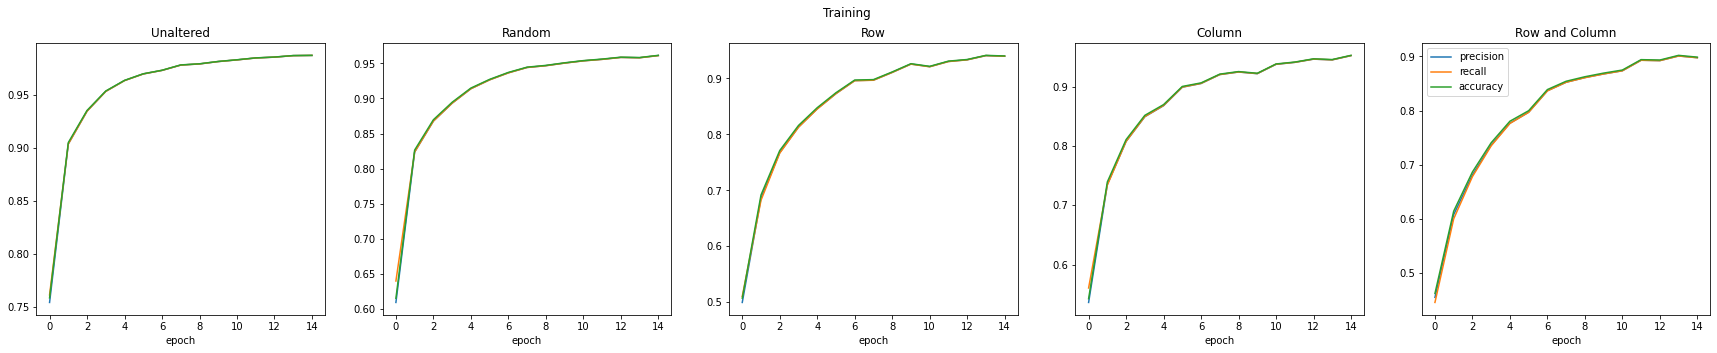

In [26]:
fig, axarr = plt.subplots(1,len(model_metrics),figsize=(30,5))
for i, (name,metrics) in enumerate(model_metrics):
        plt.sca(axarr[i])
        display_training_metrics(name,metrics)
leg = ['precision','recall','accuracy']
plt.legend(leg)
plt.suptitle('Training')
plt.show()

# Cross Table Of Data Loss Models Tested on each others Data sets

In [27]:
# model_list = [('Unaltered',model_1),('Random Per Image',model_2)]#,('Checkered',None),('Column',None),('Row',None)] # list of all the trained models
# func_list = [('Unaltered',getattr(dloss, 'unaltered')),('Random Per Image',getattr(dloss, 'random_per_img'))]
percents = [x/10.0 for x in range(11)] # input parameters to DataLoss
crosstab = {name:{func_name:{percent:[] for percent in percents} for (func_name,_) in func_list} for (name,_) in model_list} # each model has a metric for each 

# testing loop

bar = progressbar.ProgressBar(len(func_list)*len(percents),widgets=widgets).start()
for cc,(func_name,func) in enumerate(func_list): # number of data loss functions including unaltered
    for pl, ppp in enumerate(percents):

        for (name,model) in model_list:
            model.metric.reset_confusion_matrix(10)

        with torch.no_grad():
            for i, (inputs, labels) in enumerate(test_loader):
                inputs = func(inputs=inputs,ppp=ppp)
                for (model_name,model) in model_list:
                    outputs = model(inputs.to(device))
                    # statistics
                    model.metric.update_confusion_matrix(outputs.to('cpu'),labels)
                    # progressbar
            for (model_name,model) in model_list:
                crosstab[model_name][func_name][ppp] = model.metric.classification_metrics()
            bar.update(cc*len(percents) + pl)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


In [28]:
crosstab.keys()

dict_keys(['Unaltered', 'Random', 'Row', 'Column', 'Row and Column'])

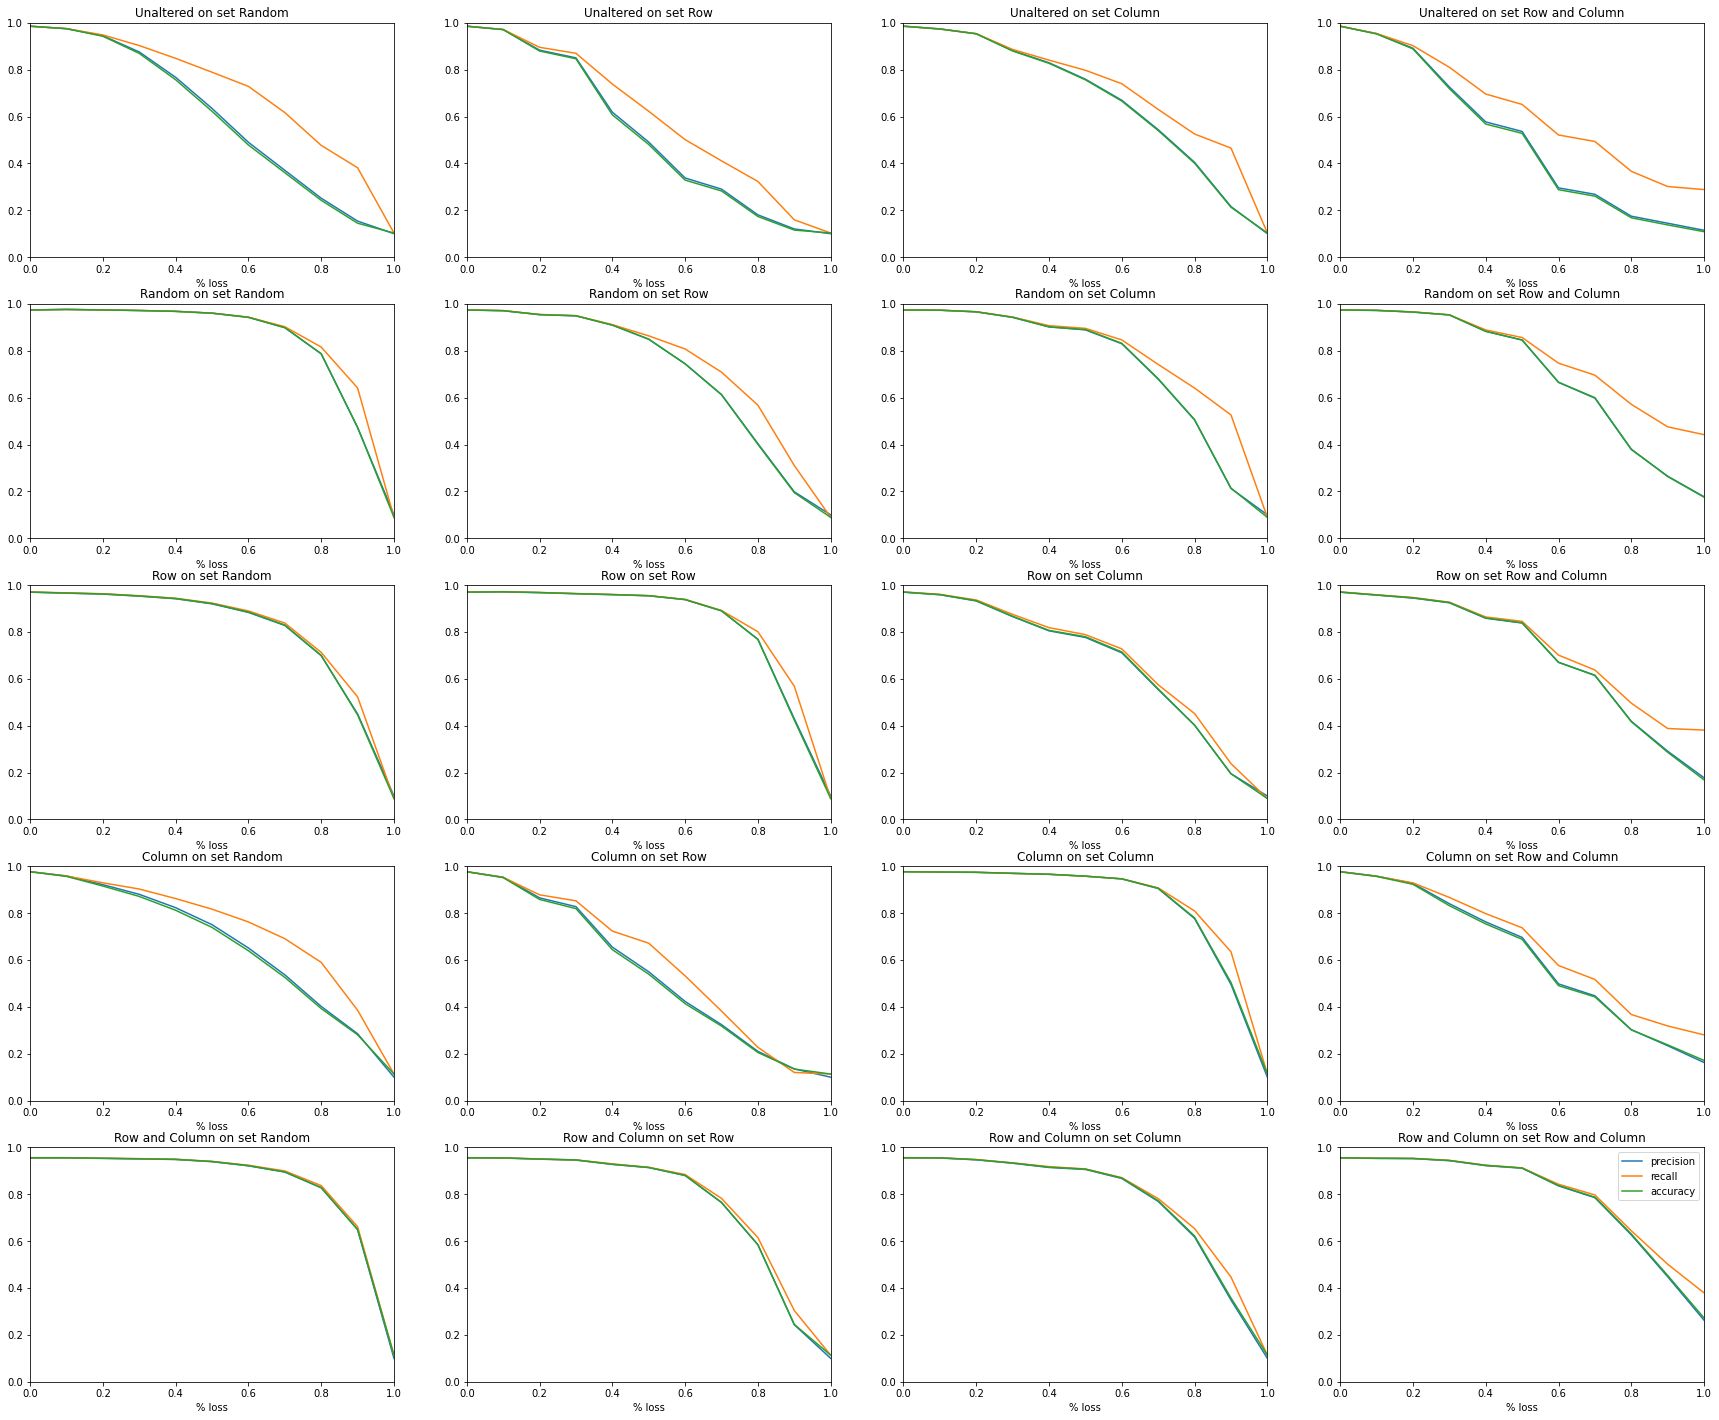

In [29]:

fig, axarr = plt.subplots(len(crosstab.keys()), len(crosstab[list(crosstab.keys())[0]].keys()),figsize=(30,25))
for i, model in enumerate(crosstab.keys()):
    for j, func in enumerate(crosstab[model].keys()):
        plt.sca(axarr[i, j])
        display_testing_metrics("{} on set {}".format(model,func),crosstab[model][func])
leg = ['precision','recall','accuracy']
plt.legend(leg)
#     plt.setp(axarr[0, i], xlabel=model)
#     plt.setp(axarr[i, 0], ylabel=model)
